In [76]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

less_than = ['mediocre compared to','flat throw','low','worse in','worst'
             'bad at','worse than','sssllllloooowwww','heavy','heavier',
             'heaviest','slower','slow','lack','sacrifice','less','lesser',
             'lower','not as','least','expensive','little fast for','not spinny enough',
             'too ','absorbing a lot of the spin potential']

greater = ['thinner','thiner','miles ahead','lasts','last longer','lasting','bouncier','good for','good deal of',
           'prefer','appreciate','enough','thicker','firmer','higher throw',
'easier to','nice','great','fine for looping','medium-high throw','high throw',
'faster','spinnier','spinner','shorter trajectory','speedy','plent speed','spinney','spiny','spinny','speedier',
'spinnier','keeps on spinning','massive spin','monster spin','extreme','fast spins','fast spin','faster',
'better','plenty of','heavy spin','good control','good spin','good speed','cheaper',
'generate tons of spin','fast','insensitive to spin','good grip','grippier','quicker',
'more','better','higher','easier','softer','faster','excellent','light','ligter','lightest',
           'tacky','extremely fast','hardest','harder','best','driving']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'ok speed','same as','so so','as good as','equally',
        'little difference','could cope with','outclasses','very much like','closer to',
         'similiar','not much different','no big difference']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
        
    assign_words(sentences_df,'spin|rotate','spin')
    assign_words(sentences_df,'fast|speed|slow','speed')
    assign_words(sentences_df,'hard|soft','hardness')
    assign_words(sentences_df,'tack|grip|sticky','tackiness') #stiff not useful- usually stiff blades
    assign_words(sentences_df,'control','control')
    assign_words(sentences_df,'bounc|lively','bounce')
    assign_words(sentences_df,'arc|angle|throw|flat|high arc|high throw','throw')
    assign_words(sentences_df,'durable|last long|long last','durability')
    assign_words(sentences_df,'for block','blocking')
    assign_words(sentences_df,'for loop|driv','looping')
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)
    
    
    # this part is for getting multiple word labels
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]

    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('better')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
    
    # this is good for having only one aspect in the sentence
    sentences_df['comparative_word_begin_idx_first'] = -1000
    
    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1:
                sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                sentences_df.loc[idx,'comparative_first'] = 'less'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first']== -1000:
            for greater_word in greater:
                location = sentence.find(greater_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'better'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first'] == -1000:
            for equal_word in equal:
                location = sentence.find(equal_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'equal'
                    
    sentences_df['specific_aspects_cnt'] = sentences_df['spin']+sentences_df['speed']+\
                                        sentences_df['hardness']+sentences_df['tackiness']+\
                                        sentences_df['control']+sentences_df['bounce']+\
                                        sentences_df['throw']+sentences_df['durability']+\
                                        sentences_df['blocking']+sentences_df['looping']

    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

    sentences_df['overall'] = sentences_df['overall'].fillna(0)

    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)

    df = assign_comparative(df)
    
    return df, df_raw


In [77]:
df, df_raw = do_the_thing('../Comparison/final_eval_2.csv')

df_comp = df[df['classification']=='comparative']
df_desc = df[df['classification']=='descriptive']

In [78]:
def print_row_info(row, ind):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  aspects: {0}'.format(find_aspects(row)))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

In [79]:
for ind, row in df_comp.iterrows():
    if row['specific_aspects_cnt']==1:
        asp = find_aspects(row)[0]
        num_entity = len(set(row.entity))
        if num_entity > 0 and contains_rub(row.entity,'Tenergy'):
            if num_entity == 2 and len(row.comparative_words) > 0:
                print_row_info(row, ind)
                if row.entity_locs[0] < row.entity_locs[1]:
                    A = row.entity[0]
                    B = row.entity[1]
                else:
                    B = row.entity[0]
                    A = row.entity[1]                    
                print('  identification: {0} - {1} - {2} - {3}'.format(asp,A,row.comparative_words[0],B))
            


[1234] 05 feels a bit harder to me than this rubber,64 feels softer.
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-05', 'Butterfly-Tenergy-64']
  comparative relation: ['better', 'better']
  comparative words: ['softer', 'harder']
  thread title: Tibhar Evolution MX-P vs Butterfly Tenergy 64
  identification: hardness - Butterfly-Tenergy-05 - softer - Butterfly-Tenergy-64
[2119] t64 dosent have a softer sponge, have the same one as t05, but the wider spaced pips gives a softer felling , and t64 is ligther cause have less pips...
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tenergy-05', 'Butterfly-Tenergy-64']
  comparative relation: ['less', 'better', 'equal']
  comparative words: ['less', 'softer', 'same']
  thread title: Modern defender - Tenergy 05 vs Tenergy 64
  identification: hardness - Butterfly-Tenergy-64 - less - Butterfly-Tenergy-05
[3071] The Rakza felt mushy, way too soft and horrible compared to the harder more positive direct feeling 05

In [9]:
# get a sense of what rubber comparisons are worth making

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def accum_col(df):
    p = []
    df.apply(lambda l: p.extend(set(l)))
    return p

def plot_most_bar(p,num):
    most = Counter(p).most_common()

    x, y = [], []
    for word,count in most[:num]:
        x.append(word)
        y.append(count)

    plt.figure(figsize=(15,3*num/10.0))
    ax = sns.barplot(x=y,y=x)    
    

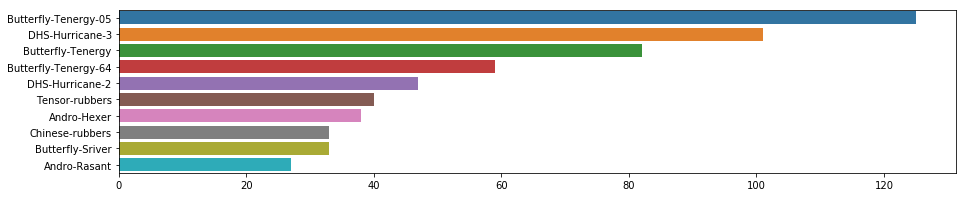

In [10]:
plot_most_bar(accum_col(df_comp['entity']),10)

# Try separating out the comparative words to identify aspect simultaneously

In [230]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

aspects = ['spin','speed','hardness','tackiness','weight','control','throw angle','durability','blocking','looping']
sw = [None]*len(aspects)
lt, gt, eq = [None]*len(aspects), [None]*len(aspects), [None]*len(aspects)
# spin
sw[0]='spin|rotate'
lt[0]=['not as spin','not spinny enough','less spin','harder to spin',
       'harder to put spin','not spinny enough','absorbing a lot of the spin potential']
gt[0]=['spinnier','more spin','spinner','spinier','generate tons of spin']
eq[0]=['as spinny as']
# speed
sw[1]='fast|speed|slow|bounc|lively'
lt[1]=['not as fast','not as bounc','slower','slow','sssllllloooowwww','less lively']
gt[1]=['not as slow','faster','bouncier','quicker','speedier','livelier']
eq[1]=['as fast as','as slow as','as bouncy as']
# hardness
sw[2]='hard|soft'
lt[2]=['softer','not as hard']
gt[2]=['firmer','harder','hardest','not as soft']
eq[2]=['as hard as','as soft as']
# tackiness
sw[3]='tack|grip|sticky'
lt[3]=['not as stick','not as tack','not as grip']
gt[3]=['tackier','stickier','good grip','grippier']
eq[3]=['as sticky as','as grippy as','as tacky as']
# weight
sw[4]='heav|light|weigh'
lt[4]=['not as heavy','ligter','lightest']
gt[4]=['not as light','heavier','heaviest']
eq[4]=['as heavy as','as light as']
# control
sw[5]='control'
lt[5]=['not as easy to control','not as much control','harder to control','worse control']
gt[5]=['more control','easier to control','better control','good control','more control']
eq[5]=['as easy to control','as good control']
# throw angle
sw[6]='arc|angle|throw|flat|high arc|high throw'
lt[6]=['not as high','flat throw',' lower','lower throw','shorter trajectory']
gt[6]=['not as low','higher','higher throw','longer trajectory','medium-high throw']
eq[6]=['similar throw']
# durability
sw[7]='durable|last long|long last'
lt[7]=['lifetime is shorter','shorter lifetime','chips away']
gt[7]=['lifetime is longer','longer lifetime','more durable','lasts longer']
eq[7]=['last as long as','lasts as long as','as durable as']
# blocking
sw[8]='for block'
lt[8]=[]
gt[8]=[]
eq[8]=[]
# driving
sw[9]='for loop|for driv'
lt[9]=[]
gt[9]=[]
eq[9]=[]

less_than = ['mediocre compared to','low','worse in','worst'
             'bad at','worse than',
             'lack','sacrifice','less','lesser',
             'not as','least',
             'too ','not as good compared to']

greater = ['miles ahead','good for','greater deal of',
           'prefer','thicker','firmer',
           'easier','nicer','greater','speedy','plent speed','spinney','spiny','spinny',
           'better','more','better','easier','best','outclasses']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'same as','so so','as good as','equally',
        'little difference','could cope with','very much like','closer to','close to',
        'similiar','not much different','no big difference']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def sub_and_find_rubbers(s):
    sub = sub_rubber_names(s)
    words = word_process(sub)
    entity, entity_locs = find_rubbers(words)    
    return sub, words, entity, entity_locs

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
          
    for i,asp in enumerate(aspects):
        assign_words(sentences_df,sw[i],asp)
    
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)
    
    
    # 
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]    
    sentences_df['comparative_words'] = [[]] * sentences_df.shape[0]        
    sentences_df['comparative_aspects'] = [[]] * sentences_df.shape[0]        
    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        comp_asp_list = []
        for i, asp in enumerate(aspects):
            for lesser_word in lt[i]:
                location = sentence.find(lesser_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('less')
                    word_list.append(lesser_word)
                    comp_asp_list.append(asp)
            for greater_word in gt[i]:
                location = sentence.find(greater_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('better')
                    word_list.append(greater_word)
                    comp_asp_list.append(asp)
            for lesser_word in lt[i]:
                location = sentence.find(lesser_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('less')
                    word_list.append(lesser_word)
                    comp_asp_list.append(asp)                    
            for equal_word in eq[i]:
                location = sentence.find(equal_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('equal')
                    word_list.append(equal_word)  
                    comp_asp_list.append(asp)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
        sentences_df.at[idx,'comparative_aspects'] = comp_asp_list
        
        
                    
    sentences_df['specific_aspects_cnt'] = sentences_df['spin']+sentences_df['speed']+\
                                        sentences_df['hardness']+sentences_df['tackiness']+\
                                        sentences_df['control']+sentences_df['weight']+\
                                        sentences_df['throw']+sentences_df['durability']+\
                                        sentences_df['blocking']+sentences_df['looping']

#    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
#                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

#    sentences_df['overall'] = sentences_df['overall'].fillna(0)

#    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    #df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    #df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    #df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)
    df[['reply_sub','reply_words','entity','entity_locs']] = \
                        df['reply_split'].apply(sub_and_find_rubbers).apply(pd.Series)

    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)    
    
    df = assign_comparative(df)
    
    return df, df_raw


In [229]:
df, df_raw = do_the_thing('../Comparison/final_eval_3.csv')

df_comp = df[df['classification']=='comparative']
df_desc = df[df['classification']=='descriptive']

In [234]:
def print_row_info(row, ind):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  aspects: {0}'.format(find_aspects(row)))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  comparative aspects: {0}'.format(row.comparative_aspects))    
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

In [220]:
# find immediately preceding index
def find_immed_preceding(loc_list, loc):
    if len(loc_list) > 0:
        loc_sorted = np.sort(loc_list)
        ind = -1
        for i,l in enumerate(loc_sorted):
            if loc > l:
                ind = i
            else:
                break
        if ind == -1:
            return -1
        else:
            return np.where(np.argsort(loc_list)==ind)[0][0]
    else:
        return -1

def find_other_ent(ent_list, ent):
    for e in ent_list:
        if e != ent:
            return e
    return None


In [12]:
for ind, row in df_comp.iterrows():
    if len(row['comparative_words'])>0:
        #asp = find_aspects(row)[0]
        num_entity = len(set(row.entity))
        if num_entity > 0:
            if num_entity == 2 and len(row.comparative_words) > 0:
                print_row_info(row, ind)
                print('  thread title: {0}'.format(sub_and_find_rubbers(row.thread_title)[0]))               
                for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
                    ent_ind = find_immed_preceding(row.entity_locs,l)
                    if ent_ind > -1:
                        print('  almighty comparison: {0} -- {1} -- {2} -- {3}'.format(a,row.entity[ent_ind],w,find_other_ent(row.entity,row.entity[ent_ind])))
                    else:
                        print('  almighty comparison:')

[611] Even the spinart has high and spaced interior dots (compared to tenergy) the feeling is not very hard, the only solution is to play it and see how it behaves, alternatively there is also the donic blugrip v1 but it is 50 degrees I do not think it feels as hard as spinart or 401
  aspects: ['spin', 'hardness', 'tackiness']
  rubbers: ['Butterfly-Tenergy', 'Donic-BlueGrip-V1']
  comparative relation: ['equal']
  comparative words: ['as hard as']
  comparative aspects: ['hardness']
  thread title: Victas Vs>401
  thread title: Victas Vs>401
  almighty comparison: hardness -- Donic-BlueGrip-V1 -- equal -- Butterfly-Tenergy
[810] Rakza 7 Soft is the softer sponge version of Rakza7 and is noticeably slower but with even better control than Rakza7.
  aspects: ['speed', 'control']
  rubbers: ['Yasaka-Rakza-7-Soft', 'Yasaka-Rakza-7', 'Yasaka-Rakza-7']
  comparative relation: ['less', 'less', 'better']
  comparative words: ['slower', 'softer', 'better control']
  comparative aspects: ['spe

  comparative aspects: ['speed']
  thread title: LKT RAPID SPEED VS RITC FOCUS III SNIPE
  thread title: LKT Tibhar-Rapid SPEED VS RITC FOCUS III SNIPE
  almighty comparison:
[3911] I've tried acuda s3 and found it to be a good soft backhand rubber much like a slightly firmer yet more spinney f3.
  aspects: ['spin', 'hardness', 'weight']
  rubbers: ['Donic-Acuda-S3', 'Donic-Desto-F3']
  comparative relation: ['better', 'better']
  comparative words: ['more spin', 'firmer']
  comparative aspects: ['spin', 'hardness']
  thread title: Acuda S2 vs Rakza 7
  thread title: Donic-Acuda-S2 vs Yasaka-Rakza-7
  almighty comparison: spin -- Donic-Acuda-S3 -- better -- Donic-Desto-F3
  almighty comparison: hardness -- Donic-Acuda-S3 -- better -- Donic-Desto-F3
[3926] Razka 7 all the way there is no real comparison to S2 R7 is a lot more spiny and thats what you want for an all-round attaker.If you want to be smart, put R7 on forehand and S2 on backhand.
  aspects: ['spin']
  rubbers: ['Donic-Acuda

  comparative relation: ['better']
  comparative words: ['easier to control']
  comparative aspects: ['control']
  thread title: Review: Andro Hexer according to me. (vs Roxon 450/500)
  thread title: Review: Andro-Hexer according to me. (vs Andro-Roxon-450/500)
  almighty comparison: control -- Butterfly-Tenergy-05 -- better -- Andro-Hexer
[5679] I would get Genius because it had more control and similar spin and speed to Hexer.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Tibhar-Genius', 'Andro-Hexer']
  comparative relation: ['better']
  comparative words: ['more control']
  comparative aspects: ['control']
  thread title: Genius vs Hexer
  thread title: Tibhar-Genius vs Andro-Hexer
  almighty comparison: control -- Tibhar-Genius -- better -- Andro-Hexer
[5680] Barracuda (Red Max on a Viscaria blade) felt a lot softer than Tenergy 64 or 05 and was markedly slower, I thought it was too slow.
  aspects: ['speed', 'hardness']
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tener

  almighty comparison: throw angle -- Andro-Rasant -- less -- Donic-Bluefire-JP-03
  almighty comparison: throw angle -- Andro-Rasant -- less -- Donic-Bluefire-JP-03
[10012] Sriver also fits the characteristics you describe, albeit slower generally than bryce speed.
  aspects: ['speed']
  rubbers: ['Butterfly-Sriver', 'Butterfly-Bryce-Speed']
  comparative relation: ['less']
  comparative words: ['slower']
  comparative aspects: ['speed']
  thread title: Hammond Pro Beta for block/drive/smash?or other suggestions?
  thread title: Hammond Pro Beta for block/drive/smash?or other suggestions?
  almighty comparison: speed -- Butterfly-Sriver -- less -- Butterfly-Bryce-Speed
[10064] However it is quite a fast, spinny and high performance rubber, and comparing it to T05 is not too far fetched, as it does similarities.Short game - Moon is a little slower, deader and spinnier, partially due to the tacky of the moon.
  aspects: ['spin', 'speed', 'tackiness']
  rubbers: ['Butterfly-Tenergy-05', 

[14953] In my experience SP has a higher throw than H2 and H3.
  aspects: ['throw angle']
  rubbers: ['DHS-Hurricane-2', 'DHS-Hurricane-3']
  comparative relation: ['better']
  comparative words: ['higher']
  comparative aspects: ['throw angle']
  thread title: Rubbers that feels like Hurricane 2 or 3
  thread title: Rubbers that feels like DHS-Hurricane-2 or 3
  almighty comparison:
[15011] Due to the lower throw, it is probably nearer to H2 than H3.
  aspects: ['throw angle']
  rubbers: ['DHS-Hurricane-2', 'DHS-Hurricane-3']
  comparative relation: ['less', 'less']
  comparative words: [' lower', 'lower throw']
  comparative aspects: ['throw angle', 'throw angle']
  thread title: Rubbers that feels like Hurricane 2 or 3
  thread title: Rubbers that feels like DHS-Hurricane-2 or 3
  almighty comparison:
  almighty comparison:
[15193] I'd say those hard tensors are maybe 10-15% faster than unglued bryce,hammond at best.
  aspects: ['speed', 'hardness']
  rubbers: ['Tensor-rubbers', 'Bu

# ==========================================================
# incorporate generic comparative words back in

In [1]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

aspects = ['spin','speed','hardness','tackiness','weight','control','throw angle','durability','blocking','looping']
sw = [None]*len(aspects)
lt, gt, eq = [None]*len(aspects), [None]*len(aspects), [None]*len(aspects)
# spin
sw[0]='spin|rotate'
lt[0]=['not as spin','not spinny enough','less spin','harder to spin',
       'harder to put spin','not spinny enough','absorbing a lot of the spin potential']
gt[0]=['spinnier','more spin','spinner','spinier','generate tons of spin']
eq[0]=['as spinny as']
# speed
sw[1]='fast|speed|slow|bounc|lively'
lt[1]=['not as fast','not as bounc','slower','slow','sssllllloooowwww','less lively']
gt[1]=['not as slow','faster','bouncier','quicker','speedier','livelier']
eq[1]=['as fast as','as slow as','as bouncy as']
# hardness
sw[2]='hard|soft'
lt[2]=['softer','not as hard']
gt[2]=['firmer','harder','hardest','not as soft']
eq[2]=['as hard as','as soft as']
# tackiness
sw[3]='tack|grip|sticky'
lt[3]=['not as stick','not as tack','not as grip']
gt[3]=['tackier','stickier','good grip','grippier']
eq[3]=['as sticky as','as grippy as','as tacky as']
# weight
sw[4]='heav|light|weigh'
lt[4]=['not as heavy','ligter','lightest']
gt[4]=['not as light','heavier','heaviest']
eq[4]=['as heavy as','as light as']
# control
sw[5]='control'
lt[5]=['not as easy to control','not as much control','harder to control','worse control']
gt[5]=['more control','easier to control','better control','good control','more control']
eq[5]=['as easy to control','as good control']
# throw angle
sw[6]='arc|angle|throw|flat|high arc|high throw'
lt[6]=['not as high','flat throw',' lower','lower throw','shorter trajectory']
gt[6]=['not as low','higher','higher throw','longer trajectory','medium-high throw']
eq[6]=['similar throw']
# durability
sw[7]='durable|last long|long last'
lt[7]=['lifetime is shorter','shorter lifetime','chips away']
gt[7]=['lifetime is longer','longer lifetime','more durable','lasts longer']
eq[7]=['last as long as','lasts as long as','as durable as']
# blocking
sw[8]='for block'
lt[8]=[]
gt[8]=[]
eq[8]=[]
# driving
sw[9]='for loop|for driv'
lt[9]=[]
gt[9]=[]
eq[9]=[]

less_than = ['mediocre compared to','low','worse in','worst'
             'bad at','worse than',
             'lack','sacrifice','less','lesser',
             'not as','least',
             'too ','not as good compared to','isn\'t as']

greater = ['miles ahead','good for','greater deal of',
           'prefer','thicker','firmer',
           'easier','nicer','greater','speedy','plent speed','spinney','spiny','spinny',
           'better','more','better','easier','best','outclasses']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'same as','so so','as good as','equally',
        'little difference','could cope with','very much like','closer to','close to',
        'similiar','not much different','no big difference','isn\'t too different','isn\'t very different']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def sub_and_find_rubbers(s):
    sub = sub_rubber_names(s)
    words = word_process(sub)
    entity, entity_locs = find_rubbers(words)    
    return sub, words, entity, entity_locs

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
          
    for i,asp in enumerate(aspects):
        assign_words(sentences_df,sw[i],asp)
    
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)

    sentences_df['specific_aspects_cnt'] = sentences_df[[x for x in aspects]].sum(axis=1)
    
    
    # general comparative words
    # this part is for getting multiple word labels
    sentences_df['g_comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['g_comparative'] = [[]] * sentences_df.shape[0]
    sentences_df['g_comparative_words'] = [[]] * sentences_df.shape[0]    
    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('greater')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'g_comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'g_comparative'] = sentiment_list
        sentences_df.at[idx,'g_comparative_words'] = word_list
    
    
    # aspect specific comparative words
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]    
    sentences_df['comparative_words'] = [[]] * sentences_df.shape[0]        
    sentences_df['comparative_aspects'] = [[]] * sentences_df.shape[0]        
    for idx,sentence in sentences_df.reply_sub.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        comp_asp_list = []
        for i, asp in enumerate(aspects):
            for lesser_word in lt[i]:
                location = sentence.find(lesser_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('less')
                    word_list.append(lesser_word)
                    comp_asp_list.append(asp)
            for greater_word in gt[i]:
                location = sentence.find(greater_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('greater')
                    word_list.append(greater_word)
                    comp_asp_list.append(asp)                   
            for equal_word in eq[i]:
                location = sentence.find(equal_word)
                if location != -1 and location not in loc_list:
                    loc_list.append(location)
                    sentiment_list.append('equal')
                    word_list.append(equal_word)  
                    comp_asp_list.append(asp)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
        sentences_df.at[idx,'comparative_aspects'] = comp_asp_list
        
                         
#    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
#                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

#    sentences_df['overall'] = sentences_df['overall'].fillna(0)

#    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    df[['reply_sub','reply_words','entity','entity_locs']] = \
                        df['reply_split'].apply(sub_and_find_rubbers).apply(pd.Series)

    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)    
    
    df = assign_comparative(df)
    
    return df, df_raw


In [2]:
df1, df_raw1 = do_the_thing('../Comparison/final_eval_1.csv')
df_comp1 = df1[df1['classification']=='comparative']
df_desc1 = df1[df1['classification']=='descriptive']

df2, df_raw2 = do_the_thing('../Comparison/final_eval_2.csv')
df_comp2 = df2[df2['classification']=='comparative']
df_desc2 = df2[df2['classification']=='descriptive']

df3, df_raw3 = do_the_thing('../Comparison/final_eval_3.csv')
df_comp3 = df3[df3['classification']=='comparative']
df_desc3 = df3[df3['classification']=='descriptive']

df_all = pd.concat([df1,df2,df3])
df_comp = pd.concat([df_comp1,df_comp2,df_comp3])
df_desc = pd.concat([df_desc1,df_desc2,df_desc3])

In [3]:
df_all.to_csv('df_all.csv')
df_comp.to_csv('df_comp.csv')
df_desc.to_csv('df_desc.csv')

In [4]:
# helper functions

def print_row_info(row, ind):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  aspects: {0}'.format(find_aspects(row)))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  comparative aspects: {0}'.format(row.comparative_aspects))    
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

# find immediately preceding index
def find_immed_preceding(loc_list, loc):
    if len(loc_list) > 0:
        loc_sorted = np.sort(loc_list)
        ind = -1
        for i,l in enumerate(loc_sorted):
            if loc > l:
                ind = i
            else:
                break
        if ind == -1:
            return -1
        else:
            return np.where(np.argsort(loc_list)==ind)[0][0]
    else:
        return -1

def find_other_ent(ent_list, ent):
    for e in ent_list:
        if e != ent:
            return e
    return None


In [5]:
# output to csv
df_output = pd.DataFrame(columns=['id','comment_id','comment_text','entity1','entity2','aspect','direction'])
for ind, row in df_comp.iterrows():
    num_entity = len(set(row.entity))
    if num_entity == 2 and len(row.comparative_words)> 0: 
        print_row_info(row, ind)
        for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
            ent_ind = find_immed_preceding(row.entity_locs,l)
            if ent_ind > -1:
                entities = [row.entity[ent_ind],find_other_ent(row.entity,row.entity[ent_ind])]
                print('  almighty comparison: {0} -- {1} -- {2} -- {3}'
                      .format(a,entities[0],w,entities[1]))
                
                alph_small_entity = min(entities[0],entities[1])
                if entities[0] == alph_small_entity:
                    entry = {'comment_id':row.id,'comment_text':row.reply_split,\
                            'entity1':entities[0], 'entity2':entities[1], 'aspect':a, 'direction':w[0]}
                else:
                    if w == 'greater':
                        w2 = 'less'
                    elif w == 'less':
                        w2 = 'greater'
                    elif w == 'equal':
                        w2 = 'equal'
                    entry = {'comment_id':row.id,'comment_text':row.reply_split,\
                            'entity1':entities[1], 'entity2':entities[0], 'aspect':a, 'direction':w2[0]}
                df_output = df_output.append(entry, ignore_index=True)

[2] I used T05fx before and I really appreciate the general feeling of the T64fx, which is more softer but faster than 05fx.
  aspects: ['speed', 'hardness']
  rubbers: ['Butterfly-Tenergy-05-FX', 'Butterfly-Tenergy-64-FX', 'Butterfly-Tenergy-05-FX']
  comparative relation: ['greater', 'less']
  comparative words: ['faster', 'softer']
  comparative aspects: ['speed', 'hardness']
  thread title: Tenergy 05FX vs Tenergy 64FX
  almighty comparison: speed -- Butterfly-Tenergy-64-FX -- greater -- Butterfly-Tenergy-05-FX
  almighty comparison: hardness -- Butterfly-Tenergy-64-FX -- less -- Butterfly-Tenergy-05-FX
[91] T80 has a little bit more control (for me), less sensitive to spin, but T05 is spinnier.
  aspects: ['spin', 'control']
  rubbers: ['Butterfly-Tenergy-80', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater']
  comparative words: ['spinnier', 'more control']
  comparative aspects: ['spin', 'control']
  thread title: Tenergy 05 vs Tenergy 80
  almighty comparis

  almighty comparison: control -- Tibhar-Evolution-EL-P -- greater -- Xiom-Vega-Pro
[1823] When compared H3 neo and H8, the H8 is slightly softer and has less tackiness so that's mean less spinny than H3 neo and also that means it gives you a bit more of control when playing even if you just start to use it
  aspects: ['spin', 'hardness', 'tackiness', 'weight', 'control']
  rubbers: ['DHS-Hurricane-3', 'DHS-Hurricane-8', 'DHS-Hurricane-8', 'DHS-Hurricane-3']
  comparative relation: ['less', 'less']
  comparative words: ['less spin', 'softer']
  comparative aspects: ['spin', 'hardness']
  thread title: Hurricane 3 neo vs Hurricane 8
  almighty comparison: spin -- DHS-Hurricane-8 -- less -- DHS-Hurricane-3
  almighty comparison: hardness -- DHS-Hurricane-8 -- less -- DHS-Hurricane-3
[1824] H3 neo would be close to H2 just that its a lot faster and low ball trajectory.
  aspects: ['speed']
  rubbers: ['DHS-Hurricane-3', 'DHS-Hurricane-2']
  comparative relation: ['greater']
  comparative 

  aspects: ['spin', 'speed', 'hardness', 'tackiness']
  rubbers: ['Butterfly-Tenergy', 'Tensor-rubbers']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: KTL Golden Star - NEW LKT/KTL rubber
[5484] But 10% slower than H3 Neo.729 Cream Transcend is soft for a Chinese rubber, softer than H3 Neo, 10% slower than H3 Neo, and at least 10% less spin than H3 Neo.But....I like both rubbers.
  aspects: ['spin', 'speed', 'hardness']
  rubbers: ['DHS-Hurricane-3', 'Chinese-rubbers', 'DHS-Hurricane-3', 'DHS-Hurricane-3', 'DHS-Hurricane-3']
  comparative relation: ['less', 'less', 'less']
  comparative words: ['less spin', 'slower', 'softer']
  comparative aspects: ['spin', 'speed', 'hardness']
  thread title: Keep Playing with Low Cost(Cheap) Rubbers or Bite the Bullet
  almighty comparison: spin -- DHS-Hurricane-3 -- less -- Chinese-rubbers
  almighty comparison: hardness -- Chinese-rubbers -- less -- DHS-Hurricane-3
[5556] Moon 

  aspects: ['spin', 'speed', 'control']
  rubbers: ['Donic-Bluefire-M3', 'Donic-Acuda-S3', 'Donic-Bluefire-M3']
  comparative relation: ['greater']
  comparative words: ['more spin']
  comparative aspects: ['spin']
  thread title: Max or 2.0 thickness for the Acuda S3?
  almighty comparison: spin -- Donic-Bluefire-M3 -- greater -- Donic-Acuda-S3
[7128] Try big slam 1.8 or Vario big slam which is a little slower.
  aspects: ['speed']
  rubbers: ['Donic-Baracuda-Big-Slam', 'Donic-Vario-Big-Slam']
  comparative relation: ['less']
  comparative words: ['slower']
  comparative aspects: ['speed']
  thread title: Tensor with 1.8 mm sponge or less
  almighty comparison: speed -- Donic-Vario-Big-Slam -- less -- Donic-Baracuda-Big-Slam
[7238] i havn`t tried it but just a suggestion, barracuda bigslam is a bit faster,spinnier, but slightly harder sponge than the vario bigslam
  aspects: ['spin', 'speed', 'hardness', 'weight']
  rubbers: ['Donic-Baracuda-Big-Slam', 'Donic-Vario-Big-Slam']
  compar

  comparative aspects: ['spin', 'speed', 'hardness', 'throw angle']
  thread title: Bryce Speed VS Tenergy 05 ? Or other comparisons with T05?
  almighty comparison: spin -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed
  almighty comparison: speed -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed
  almighty comparison: hardness -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed
  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed
[10273] I take it out and hit with it occasionally.You're not saying it's a clone of H2 because it's not even close to H2  It plays more like H3, but the nano sponge is softer - I guess it's a lot closer to H3 #19.
  aspects: ['hardness']
  rubbers: ['DHS-Hurricane-2', 'DHS-Hurricane-2', 'DHS-Hurricane-3', 'DHS-Hurricane-3']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Something like Hurricane 2's throw/kick...
  almi

[13234] OK, they feel about the same (the MX-P cutoff is a little tackier), but the Rasant Turbo doesn't have that same smell.
  aspects: ['tackiness']
  rubbers: ['Tibhar-Evolution-MX-P', 'Andro-Rasant-Turbo']
  comparative relation: ['greater']
  comparative words: ['tackier']
  comparative aspects: ['tackiness']
  thread title: Tibhar Aurus Prime & Aurus Select review
  almighty comparison: tackiness -- Tibhar-Evolution-MX-P -- greater -- Andro-Rasant-Turbo
[13289] I would say that R9 is LESS sensitive to spin than R7, a little faster and a little less spinny.
  aspects: ['spin', 'speed']
  rubbers: ['Yasaka-Rakza-9', 'Yasaka-Rakza-7']
  comparative relation: ['less', 'greater']
  comparative words: ['less spin', 'faster']
  comparative aspects: ['spin', 'speed']
  thread title: Rakza 7 and Rakza 9 - spin insensitive
  almighty comparison: spin -- Yasaka-Rakza-7 -- less -- Yasaka-Rakza-9
  almighty comparison: speed -- Yasaka-Rakza-7 -- greater -- Yasaka-Rakza-9
[13300] Rakza7 is me

  almighty comparison: throw angle -- DHS-Hurricane-3 -- less -- DHS-Hurricane
  almighty comparison: throw angle -- DHS-Hurricane-3 -- less -- DHS-Hurricane
[16174] There I think you want a rubber than isn't very variable in what it does or can do (H2, the champion of at the table looping comes to mind a very simple minded rubber but the best at the one or two things it knows how to do).Now about Duro, is heaps lower throw than original Hexer which is something I really enjoy in a rubber.
  aspects: ['throw angle']
  rubbers: ['DHS-Hurricane-2', 'Andro-Hexer']
  comparative relation: ['less', 'less']
  comparative words: [' lower', 'lower throw']
  comparative aspects: ['throw angle', 'throw angle']
  thread title: ANDRO HEXER QUESTIONS AND COMMENTS
  almighty comparison: throw angle -- DHS-Hurricane-2 -- less -- Andro-Hexer
  almighty comparison: throw angle -- DHS-Hurricane-2 -- less -- Andro-Hexer
[16234] I think T64 wouldn't be quite as fast as R450 for flat hitting, so I think it

  almighty comparison: speed -- DHS-Hurricane-3 -- greater -- DHS-Hurricane-2
  almighty comparison: hardness -- DHS-Hurricane-2 -- greater -- DHS-Hurricane-3
  almighty comparison: throw angle -- DHS-Hurricane-2 -- less -- DHS-Hurricane-3
  almighty comparison: throw angle -- DHS-Hurricane-2 -- less -- DHS-Hurricane-3
[20333] I agree, F2 has a higher throw angle than F1.
  aspects: ['throw angle']
  rubbers: ['Donic-Desto-F2', 'Donic-Desto-F1']
  comparative relation: ['greater']
  comparative words: ['higher']
  comparative aspects: ['throw angle']
  thread title: Donic Desto F1 and F2 max
  almighty comparison: throw angle -- Donic-Desto-F2 -- greater -- Donic-Desto-F1
[20353] In general, it is a lot better than F1 (which is itself a very good rubber).One of these days I will try F1 HS, maybe I will like it even more, who knows.NOte that I play with a Butterfly Arylate/Carbon blade with a soft feel, that may be why I prefer the slightly harder sponge.
  aspects: ['hardness', 'weight

[2795] HOWEVER: In this particular, rarity of a case only applicable to a comparison with T05, the Omega V pro is still more controllable, given that it's much deader and less bouncy on soft shots, and moreover has a less volatile topsheet (by which I mean remarkably spin sensitive) and will allow you to slightly misread the amount of spin but still get a weak return to land on the table.
  aspects: ['spin', 'speed', 'hardness', 'weight', 'control']
  rubbers: ['Butterfly-Tenergy-05', 'Xiom-Omega-V-Pro']
  comparative relation: ['greater']
  comparative words: ['more control']
  comparative aspects: ['control']
  thread title: XIOM vs Tenergy
  almighty comparison: control -- Xiom-Omega-V-Pro -- greater -- Butterfly-Tenergy-05
[2826] Xiom OVT is much harder than T05FX and regular T05 for that matter.
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-05-FX', 'Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['harder']
  comparative aspects: ['hardness

[4264] There lies the problem to define which rubber is faster...The Jupiter has a much harder sponge, whereas the mercury II has a soft springier sponge.
  aspects: ['speed', 'hardness']
  rubbers: ['Galaxy-Jupiter', 'Galaxy-Mercury-II']
  comparative relation: ['greater', 'greater']
  comparative words: ['faster', 'harder']
  comparative aspects: ['speed', 'hardness']
  thread title: Jupiter vs Mercury II
  almighty comparison: hardness -- Galaxy-Jupiter -- greater -- Galaxy-Mercury-II
[4282] The Coppa Tagora is a bit faster than Sriver, but also nice and soft so great control.
  aspects: ['speed', 'hardness', 'control']
  rubbers: ['Donic-Coppa-Tagora', 'Butterfly-Sriver']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Butterfly Flextra vs Donic Coppa Tenero
  almighty comparison: speed -- Donic-Coppa-Tagora -- greater -- Butterfly-Sriver
[4292] I just played with Coppa Tagora, then I fixed the guys paddle (and bo

  almighty comparison: speed -- Butterfly-Tenergy-64 -- greater -- Butterfly-Tenergy-05
[5540] IQUL 42 degree is the fastest of the lot and in my opinion is faster than Sriver and Mark V.
  aspects: ['speed']
  rubbers: ['Butterfly-Sriver', 'Yasaka-Mark-V']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Sriver El VS Mark V for BH
[5642] Interesting...I actually found T05 easier to control than Hexer...
  aspects: ['control']
  rubbers: ['Butterfly-Tenergy-05', 'Andro-Hexer']
  comparative relation: ['greater']
  comparative words: ['easier to control']
  comparative aspects: ['control']
  thread title: Review: Andro Hexer according to me. (vs Roxon 450/500)
  almighty comparison: control -- Butterfly-Tenergy-05 -- greater -- Andro-Hexer
[5679] I would get Genius because it had more control and similar spin and speed to Hexer.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Tibhar-Genius', 'Andro-Hexer']
  compar

  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- greater -- Tensor-rubbers
[10199] The throw angle is higher then venus II, D. Acuda S2, and Palio Blitz.My current blade is 7ply hinoki with a mid-soft touch, not as soft as tanpan or speed 90..
  aspects: ['speed', 'throw angle']
  rubbers: ['Galaxy-Venus', 'Donic-Acuda-S2']
  comparative relation: ['greater', 'equal', 'greater']
  comparative words: ['not as soft', 'as soft as', 'higher']
  comparative aspects: ['hardness', 'hardness', 'throw angle']
  thread title: Galaxy / Yin-He Moon Pro
  almighty comparison: hardness -- Donic-Acuda-S2 -- greater -- Galaxy-Venus
  almighty comparison: hardness -- Donic-Acuda-S2 -- equal -- Galaxy-Venus
[10495] I found Skyline TG3 Neo to be much easier to control than H3 Neo.
  aspects: ['control']
  rubbers: ['DHS-Skyline-TG3', 'DHS-Hurricane-3']
  comparative relation: ['greater']
  comparative words: ['easier to control']
  comparative aspects: ['control']
  thread title: DHS Hurrica

[15011] Due to the lower throw, it is probably nearer to H2 than H3.
  aspects: ['throw angle']
  rubbers: ['DHS-Hurricane-2', 'DHS-Hurricane-3']
  comparative relation: ['less', 'less']
  comparative words: [' lower', 'lower throw']
  comparative aspects: ['throw angle', 'throw angle']
  thread title: Rubbers that feels like Hurricane 2 or 3
[15193] I'd say those hard tensors are maybe 10-15% faster than unglued bryce,hammond at best.
  aspects: ['speed', 'hardness']
  rubbers: ['Tensor-rubbers', 'Butterfly-Bryce']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Tensor or Tensor-Like with Hard Feel
  almighty comparison: speed -- Tensor-rubbers -- greater -- Butterfly-Bryce
[15219] And I haven't had another hit with the Bryce Speed until recently (due to its high price), but I'm once again certain that BS is as fast, if not faster than 470 and the JO Gold.
  aspects: ['speed']
  rubbers: ['Butterfly-Bryce-Speed', 'Do

  almighty comparison: control -- JOOLA-Rhyzer-48 -- greater -- Xiom-Omega-VII-Asia
[4577] So far, the Omega VII Asia has the hardest sponge at 52.5 degrees and topsheet cannot be even considered as soft like the Omega VII Pro.
  aspects: ['hardness']
  rubbers: ['Xiom-Omega-VII-Asia', 'Xiom-Omega-VII-Pro']
  comparative relation: ['greater']
  comparative words: ['hardest']
  comparative aspects: ['hardness']
  thread title: Xiom Omega VII Asia Review
  almighty comparison: hardness -- Xiom-Omega-VII-Asia -- greater -- Xiom-Omega-VII-Pro
[4624]    I use T05 on the FH and T25 on the BH.When you hit flat, T25 is a little faster.When you spin, T05 is a little faster.T25 topsheet is a lot stiffer, so it is harder to engage the sponge when looping with T25.ILya
  aspects: ['spin', 'speed', 'hardness', 'throw angle']
  rubbers: ['Butterfly-Tenergy-05', 'Butterfly-Tenergy-25', 'Butterfly-Tenergy-25', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater']
  comparative words: 

[5833]    T64 sponge is the same as that of T05 (45 deg) but topsheet feels quite a bit softer in play.
  aspects: ['hardness']
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tenergy-05']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Xiom Omega V
  almighty comparison: hardness -- Butterfly-Tenergy-05 -- less -- Butterfly-Tenergy-64
[5849] The resulting medium-high arc is very nice.However, the arc produced by Omega V Tour is much lower as compared to MX-P, and the percentage of netted balls was just too high.
  aspects: ['throw angle']
  rubbers: ['Xiom-Omega-V-Tour', 'Tibhar-Evolution-MX-P']
  comparative relation: ['less']
  comparative words: [' lower']
  comparative aspects: ['throw angle']
  thread title: Xiom Omega V
  almighty comparison: throw angle -- Xiom-Omega-V-Tour -- less -- Tibhar-Evolution-MX-P
[6002] Omega V Tour is a completely different rubber, think of a Hurricane III which is a tad faster, but 

[7435] MXP seems a touch faster and harder new than 05 and the arc you get on the ball is generally lower than with 05 (I play with Viscaria) I haven't tried mxp on an all wood blade but I did try 05 on a korbel and it was fantastic.
  aspects: ['speed', 'hardness', 'throw angle']
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05', 'Butterfly-Tenergy-05', 'Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater', 'less']
  comparative words: ['faster', 'harder', ' lower']
  comparative aspects: ['speed', 'hardness', 'throw angle']
  thread title: T05 vs MXP
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
  almighty comparison: hardness -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- less -- Tibhar-Evolution-MX-P
[7440] This feels a little softer, higher throw, not quite as powerful as the MX-P, and easier to control than both M

  comparative aspects: ['throw angle']
  thread title: Tenergy05-like rubbers
[10137] It is, I think, a bit faster than T05 and T64, with less 'easy spin'.
  aspects: ['spin', 'speed']
  rubbers: ['Butterfly-Tenergy-05', 'Butterfly-Tenergy-64']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: H3Neo hardness for BH
[10370] Tenergy is made in Japan by Butterfly itself, ridiculosly grippier topsheet with 10-15 degrees of harder sponge compared to Tensors.
  aspects: ['hardness', 'tackiness']
  rubbers: ['Butterfly-Tenergy', 'Tensor-rubbers']
  comparative relation: ['greater', 'greater']
  comparative words: ['harder', 'grippier']
  comparative aspects: ['hardness', 'tackiness']
  thread title: My Tenergy shrunk ?!
  almighty comparison: hardness -- Butterfly-Tenergy -- greater -- Tensor-rubbers
  almighty comparison: tackiness -- Butterfly-Tenergy -- greater -- Tensor-rubbers
[10707]    EL-S is faster than EL-P with the 

  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Tibhar alternative to Tenergy 05fx
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
[13953] MX-P is faster and harder than my 05.
  aspects: ['speed', 'hardness']
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater']
  comparative words: ['faster', 'harder']
  comparative aspects: ['speed', 'hardness']
  thread title: Tibhar alternative to Tenergy 05fx
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
  almighty comparison: hardness -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
[14004]    At least 5q sound is not as bouncy as mxp.
  aspects: ['speed']
  rubbers: ['Tibhar-5Q-Sound', 'Tibhar-Evolution-MX-P']
  comparative relation: ['less', 'equal']
  comparative words: ['not as bounc', 'as bouncy as']
  comparative aspects: ['s

In [6]:
df_output.head()

,id,comment_id,comment_text,entity1,entity2,aspect,direction
0,NaN,5f686bc7b59794ca78c70902,I used T05fx before and I really appreciate th...,Butterfly-Tenergy-05-FX,Butterfly-Tenergy-64-FX,speed,l
1,NaN,5f686bc7b59794ca78c70902,I used T05fx before and I really appreciate th...,Butterfly-Tenergy-05-FX,Butterfly-Tenergy-64-FX,hardness,g
2,NaN,5f686bdbb59794ca78c7090b,"T80 has a little bit more control (for me), le...",Butterfly-Tenergy-05,Butterfly-Tenergy-80,spin,g
3,NaN,5f686bdbb59794ca78c7090b,"T80 has a little bit more control (for me), le...",Butterfly-Tenergy-05,Butterfly-Tenergy-80,control,l
4,NaN,5f686bdbb59794ca78c7090b,After testing Dignics 05 on a zlc blade after ...,Butterfly-Dignics-05,Butterfly-Tenergy-64-FX,spin,g


In [7]:
df_output.shape

(496, 7)

In [8]:
df_output.to_csv('rubber_comparison_output.csv',sep='|')

In [264]:
            else:
                if num_entity == 1 and len(row.comparative_words) > 0:                   
                    print_row_info(row, ind)
                #if (len(row.g_comparative) > 0) and (row.g_comparative[0] == 'equal'):
                #    print_row_info(row, ind)
                    #print('  almighty comparison: {0} -- {1} -- {2} -- {3}'
                    #      .format(find_aspects(row)[0],row.entity[0],'same',find_other_ent(row.entity[0])))

,id,thread_title,reply_split,classification,reply_sub,reply_words,entity,entity_locs,spin,speed,...,looping,throw,specific_aspects_cnt,g_comparative_word_begin_idx,g_comparative,g_comparative_words,comparative_word_begin_idx,comparative,comparative_words,comparative_aspects
52,5f6c21e7035f29fdaf67ffa8,dignics 09c vs dignics 05 review,"The Dignics plays better than the silver, thou...",comparative,The Butterfly-Dignics plays better than the si...,"[The, Butterfly-Dignics, plays, better, than, ...",[Butterfly-Dignics],[4],0.0,0.0,...,0.0,0.0,0.0,[18],[better],[better],[],[],[],[]
70,5f6c21e8035f29fdaf67ffa9,DHS Hurricane 3 Neo 2.15 vs. 2.2,"Ordinary H3 turned out to be too slow for me, ...",comparative,Ordinary DHS-Hurricane-3 turned out to be too ...,"[Ordinary, DHS-Hurricane-3, turned, out, to, b...","[DHS-Hurricane-3, DHS-NEO-Hurricane-3, Chinese...","[9, 134, 178]",0.0,1.0,...,0.0,0.0,1.0,"[34, 73, 29]","[less, less, less]","[low, least, too ]","[46, 163]","[less, better]","[slow, faster]","[speed, speed]"
173,5f6c2215035f29fdaf67ffbe,Victas Vs>401,Quite a bit faster and a little less spin.,comparative,Quite a bit faster and a little less spin.,"[Quite, a, bit, faster, and, a, little, less, ...",[],[],1.0,1.0,...,0.0,0.0,2.0,[32],[less],[less],"[32, 12]","[less, better]","[less spin, faster]","[spin, speed]"
180,5f6c2215035f29fdaf67ffbe,Victas Vs>401,"Speed is somewhat comparable to Neo H3, if I r...",comparative,Speed is somewhat comparable to DHS-NEO-Hurric...,"[Speed, is, somewhat, comparable, to, DHS-NEO-...",[DHS-NEO-Hurricane-3],[32],0.0,1.0,...,0.0,0.0,1.0,[18],[equal],[comparable],[],[],[],[]
181,5f6c2215035f29fdaf67ffbe,Victas Vs>401,The 401 is a tiny bit more lively than the usu...,comparative,The 401 is a tiny bit more lively than the usu...,"[The, 401, is, a, tiny, bit, more, lively, tha...",[Tensor-rubbers],[157],0.0,1.0,...,0.0,0.0,1.0,"[70, 22]","[less, better]","[least, more]",[],[],[],[]


In [ ]:
## graveyard for now    
    
    # this part is for getting multiple word labels
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]

    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('better')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
    
    # this is good for having only one aspect in the sentence
    sentences_df['comparative_word_begin_idx_first'] = -1000
    
    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1:
                sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                sentences_df.loc[idx,'comparative_first'] = 'less'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first']== -1000:
            for greater_word in greater:
                location = sentence.find(greater_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'better'
        if sentences_df.loc[idx,'comparative_word_begin_idx_first'] == -1000:
            for equal_word in equal:
                location = sentence.find(equal_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'equal'


In [237]:
find_aspects(row)

[]

In [233]:
df.head()

,id,thread_title,reply_split,classification,reply_sub,reply_words,entity,entity_locs,spin,speed,...,looping,throw,specific_aspects_cnt,g_comparative_word_begin_idx,g_comparative,g_comparative_words,comparative_word_begin_idx,comparative,comparative_words,comparative_aspects
8,5f6c219629a893d240caed63,chop vs spin rubber -- which characteristics d...,"More bounce, more speed.",descriptive,"More bounce, more speed.","[More, bounce, ,, more, speed, .]",[],[],0.0,1.0,...,0.0,0.0,NaN,[0],[better],[more],[],[],[],[]
52,5f6c21e7035f29fdaf67ffa8,dignics 09c vs dignics 05 review,"The Dignics plays better than the silver, thou...",comparative,The Butterfly-Dignics plays better than the si...,"[The, Butterfly-Dignics, plays, better, than, ...",[Butterfly-Dignics],[4],0.0,0.0,...,0.0,0.0,0.0,[18],[better],[better],[],[],[],[]
61,5f6c21e7035f29fdaf67ffa8,dignics 09c vs dignics 05 review,"Teessport are reliable,I've had loads of stuff...",descriptive,"Teessport are reliable,I've had loads of stuff...","[Teessport, are, reliable, ,, I, 've, had, loa...",[],[],0.0,0.0,...,0.0,0.0,1.0,[],[],[],[],[],[],[]
70,5f6c21e8035f29fdaf67ffa9,DHS Hurricane 3 Neo 2.15 vs. 2.2,"Ordinary H3 turned out to be too slow for me, ...",comparative,Ordinary DHS-Hurricane-3 turned out to be too ...,"[Ordinary, DHS-Hurricane-3, turned, out, to, b...","[DHS-Hurricane-3, DHS-NEO-Hurricane-3, Chinese...","[9, 134, 178]",0.0,1.0,...,0.0,0.0,NaN,"[34, 73, 29]","[less, less, less]","[low, least, too ]","[46, 163]","[less, better]","[slow, faster]","[speed, speed]"
81,5f6c21e8035f29fdaf67ffa9,DHS Hurricane 3 Neo 2.15 vs. 2.2,The 2.15 felt easier for me to use on my Bh.,descriptive,The 2.15 felt easier for me to use on my Bh.,"[The, 2.15, felt, easier, for, me, to, use, on...",[],[],0.0,0.0,...,0.0,0.0,NaN,[14],[better],[easier],[],[],[],[]
